In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from wordcloud import WordCloud
import re
import random
import textwrap

import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [26]:
PATH = "../data/outputs/sample-data-export-clean.csv"

df = pd.read_csv(PATH, sep=',')

In [27]:
df.head()

id                                        description
0   1  Active classic boxers - There's a reason why o...
1   2  Active sport boxer briefs - Skinning up Glory ...
2   3  Active sport briefs - These superbreathable no...
3   4  Alpine guide pants - Skin in, climb ice, switc...
4   5  Alpine wind jkt - On high ridges, steep ice an...

# Preprocessing

In [28]:
# Baseline
def simple_clean(text: str) -> str:
    text = str(text).lower()
    text = re.sub(r"http\S+|www\.\S+", " ", text)
    text = re.sub(r"[^a-zàâçéèêëîïôûùüÿñæœ\s-]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["clean"] = df["description"].map(simple_clean)

# Spacy
nlp = spacy.load("fr_core_news_sm", disable=["ner", "parser"])

def spacy_lemma(text: str) -> str:
    doc = nlp(text)
    toks = [
        t.lemma_.lower()
        for t in doc
        if not t.is_stop and not t.is_punct and not t.is_space and len(t) > 2
    ]
    return " ".join(toks)

df["clean_spacy"] = df["clean"].map(spacy_lemma)

In [29]:
# Prise en charge des balises HTML
STOP_EXTRA = {"br", "ul", "li", "oz", "dwr"}

def drop_extra(text: str) -> str:
    return " ".join([t for t in text.split() if t not in STOP_EXTRA])

df["clean"] = df["clean"].map(drop_extra)
df["clean_spacy"] = df["clean_spacy"].map(drop_extra)

In [30]:
df[["id", "description", "clean", "clean_spacy"]].head(3)

id                                        description  \
0   1  Active classic boxers - There's a reason why o...   
1   2  Active sport boxer briefs - Skinning up Glory ...   
2   3  Active sport briefs - These superbreathable no...   

                                               clean  \
0  active classic boxers - there s a reason why o...   
1  active sport boxer briefs - skinning up glory ...   
2  active sport briefs - these superbreathable no...   

                                         clean_spacy  
0  actif classic boxer there reason why our boxer...  
1  actif sport boxer brief skinning glory require...  
2  active sport brief these superbreathabl fly br...

# TF-IDF

In [31]:
vectorizer = TfidfVectorizer(
    max_df=0.90, # coupe les termes trop fréquents
    min_df=5, # coupe les termes trop rares
    ngram_range=(1, 2), # mots + bigrammes
    stop_words="english",
)

X = vectorizer.fit_transform(df["clean_spacy"])

print("TF-IDF shape:", X.shape)
print("Vocabulaire size:", len(vectorizer.get_feature_names_out()))
print("Vocabulaire :", vectorizer.vocabulary_)
print("Vecorizer :", vectorizer)

TF-IDF shape: (500, 2582)
Vocabulaire size: 2582
Vocabulaire : {'actif': 13, 'classic': 288, 'boxer': 172, 'favorite': 742, 'cool': 392, 'sticky': 2137, 'quick': 1700, 'drying': 565, 'lightweight': 1170, 'minimal': 1318, 'space': 2080, 'travel': 2330, 'pack': 1449, 'exposed': 665, 'brushed': 203, 'waistband': 2418, 'offer': 1405, 'skin': 1981, 'softnes': 2068, 'fiv': 787, 'panel': 1467, 'construction': 374, 'traditional': 2320, 'faire': 727, 'functional': 843, 'fly': 816, 'recycled': 1728, 'polyester': 1582, 'moistur': 1331, 'wicking': 2494, 'performance': 1500, 'inseam': 1022, 'size': 1971, 'recyclable': 1725, 'common': 352, 'threads': 2288, 'recycling': 1736, 'program': 1639, 'silky': 1954, 'capilene': 235, 'ultralight': 2358, 'breathabl': 182, 'dry': 555, 'elastic': 605, 'comfort': 339, 'siz': 1967, 'gladiodor': 864, 'natural': 1352, 'odor': 1399, 'control': 385, 'garment': 847, 'mexico': 1295, 'quick drying': 1703, 'skin softnes': 1992, 'panel construction': 1468, 'functional fly':

# Clustering avec DBSCAN (cosine)

In [32]:
def dbscan_report(eps, min_samples):
    model = DBSCAN(eps=eps, min_samples=min_samples, metric="cosine", n_jobs=-1)
    labels = model.fit_predict(X)
    n_noise = int((labels == -1).sum())
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    return {
        "eps": eps,
        "min_samples": min_samples,
        "clusters": n_clusters,
        "noise_ratio": n_noise / len(labels),
    }

results = []
for eps in [0.45, 0.50, 0.55]:
    for ms in [3,5,8,10]:
        results.append(dbscan_report(eps, ms))

res_df = pd.DataFrame(results).sort_values(["clusters", "noise_ratio"], ascending=[False, True])
res_df.head(20)

eps  min_samples  clusters  noise_ratio
4   0.50            3        52        0.326
8   0.55            3        49        0.200
0   0.45            3        43        0.440
9   0.55            5        27        0.404
5   0.50            5        23        0.558
1   0.45            5        17        0.642
10  0.55            8        11        0.618
6   0.50            8         7        0.756
2   0.45            8         7        0.766
11  0.55           10         6        0.728
7   0.50           10         4        0.808
3   0.45           10         2        0.848

In [33]:
best = res_df.iloc[4]  # Remplacer par la ligne choisie
best_eps = float(best["eps"])
best_ms = int(best["min_samples"])

dbscan = DBSCAN(eps=best_eps, min_samples=best_ms, metric="cosine", n_jobs=-1)
df["cluster"] = dbscan.fit_predict(X)

print("Best eps:", best_eps, "min_samples:", best_ms)
print(df["cluster"].value_counts().head(15))

Best eps: 0.5 min_samples: 5
cluster
-1     279
 5      61
 12     15
 11     10
 2      10
 0       9
 3       9
 4       9
 17      8
 8       8
 20      7
 16      7
 10      7
 6       7
 9       6
Name: count, dtype: int64


## Aperçu des clusters

In [34]:
terms = np.array(vectorizer.get_feature_names_out())

def top_terms_for_cluster(cluster_id, top_k=15):
    idx = np.where(df["cluster"].values == cluster_id)[0]
    if len(idx) == 0:
        return []
    mean_tfidf = X[idx].mean(axis=0).A1
    top_idx = mean_tfidf.argsort()[::-1][:top_k]
    return list(terms[top_idx])

# Afficher un résumé des clusters (hors noise)
cluster_ids = sorted([c for c in df["cluster"].unique() if c != -1])
print("Clusters:", len(cluster_ids), "Noise ratio:", (df["cluster"]==-1).mean())

for c in cluster_ids[:15]:
    n = int((df["cluster"] == c).sum())
    print(f"\nCluster {c} | n={n}")
    print(top_terms_for_cluster(c, top_k=12))

Clusters: 23 Noise ratio: 0.558

Cluster 0 | n=9
['coverag', 'improved fabric', 'nylon spandex', 'acros', 'lined', 'improved', 'btm', 'coverag lined', 'fabric fabric', 'spandex', 'nylon', 'rise improved']

Cluster 1 | n=5
['nylon recycled', 'partially', 'pocket', 'gusseted crotch', 'partially elasticized', 'motion', 'recycled spandex', 'gusseted', 'crotch', 'welted', 'spandex', 'nylon']

Cluster 2 | n=10
['sun protection', 'upf', 'upf sun', 'sun', 'protection', 'polyester gladiodor', 'garment upf', 'silky', 'natural odor', 'gladiodor', 'gladiodor natural', 'odor control']

Cluster 3 | n=9
['open knit', 'capilene fabric', 'garment recyclable', 'fastest', 'capilene', 'recycled gladiodor', 'control garment', 'natural odor', 'gladiodor natural', 'odor control', 'gladiodor', 'chilly day']

Cluster 4 | n=9
['smooth jersey', 'garment recyclable', 'control', 'control garment', 'beneath', 'gladiodor', 'gladiodor natural', 'odor control', 'natural odor', 'natural', 'beneath layer', 'exterior gli

## Visualisation des clusters

In [35]:
col = "cluster"

counts = df[col].value_counts().reset_index()
counts.columns = ["cluster", "count"]

counts["cluster_label"] = counts["cluster"].apply(lambda x: "Noise" if x == -1 else str(x))
counts = counts.sort_values("count", ascending=False)

total = counts["count"].sum()
counts["pct"] = counts["count"] / total

noise_ratio = (df[col] == -1).mean()

fig = px.bar(
    counts,
    x="cluster_label",
    y="count",
    text="count",
    hover_data={"count": True, "pct": ":.1%", "cluster": True, "cluster_label": False},
    title=f"Distribution des clusters DBSCAN (noise={noise_ratio:.1%})",
    labels={"cluster_label": "Cluster", "count": "Nombre de produits"},
)

fig.update_traces(textposition="outside", cliponaxis=False)
fig.update_layout(xaxis_tickangle=0)
fig.show()

## Wordcloud

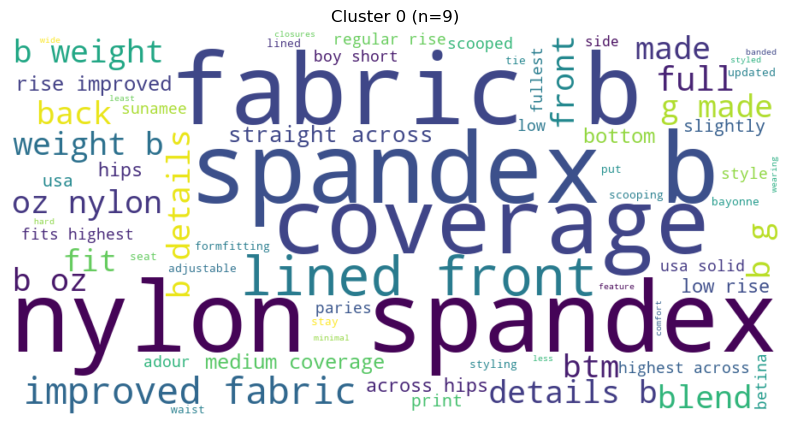

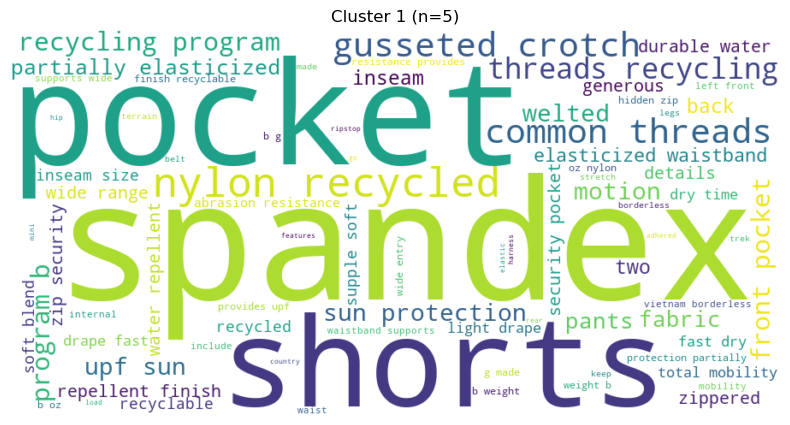

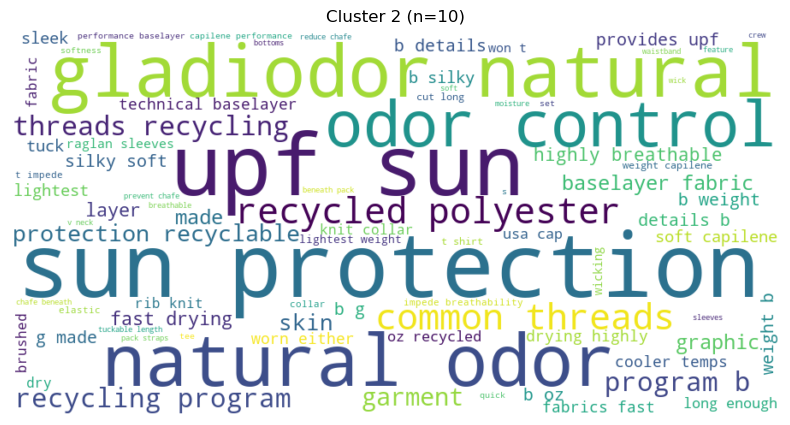

In [36]:
def plot_wordcloud_for_cluster(cluster_id, max_words=80):
    sub = df[df["cluster"] == cluster_id]["clean"].tolist()
    text = " ".join(sub)
    wc = WordCloud(width=900, height=450, background_color="white", max_words=max_words).generate(text)
    plt.figure(figsize=(12, 5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Cluster {cluster_id} (n={len(sub)})")
    plt.show()

# Exemple : affiche 3 clusters
for c in cluster_ids[:3]:
    plot_wordcloud_for_cluster(c)

# Clustering avec KMeans

In [37]:
K_RANGE = range(5, 26, 2)  # 5,7,9,...,25
inertias = []

for k in K_RANGE:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X)
    inertias.append({"k": k, "inertia": km.inertia_})

inertia_df = pd.DataFrame(inertias)
inertia_df

k     inertia
0    5  400.315510
1    7  382.819388
2    9  370.415788
3   11  356.772140
4   13  347.345399
5   15  339.229828
6   17  329.449986
7   19  321.717371
8   21  311.959421
9   23  302.877811
10  25  296.284989

In [53]:
fig = px.line(inertia_df, x="k", y="inertia", markers=True, title="KMeans inertia (elbow)")
fig.show()

In [ ]:
K = 15
kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)
df["kmeans_cluster"] = kmeans.fit_predict(X)

df["kmeans_cluster"].value_counts().sort_index()

kmeans_cluster
0     61
1     48
2     23
3     62
4     15
5     31
6     73
7     31
8      8
9     31
10    15
11    20
12    17
13    51
14    14
Name: count, dtype: int64

## Aperçu des clusters

In [40]:
terms = np.array(vectorizer.get_feature_names_out())

def top_terms_kmeans(cluster_id, top_k=12):
    center = kmeans.cluster_centers_[cluster_id]
    top_idx = center.argsort()[::-1][:top_k]
    return list(terms[top_idx])

for c in range(K):
    n = int((df["kmeans_cluster"] == c).sum())
    print(f"\nCluster {c} | n={n}")
    print(top_terms_kmeans(c, top_k=12))


Cluster 0 | n=61
['shirt', 'taped shoulder', 'taped', 'ringspun', 'pvc', 'shoulder seam', 'inks', 'phthalate free', 'pvc phthalate', 'phthalate', 'organic', 'cotton']

Cluster 1 | n=48
['sun', 'natural odor', 'odor control', 'gladiodor', 'control', 'gladiodor natural', 'upf', 'natural', 'odor', 'sun protection', 'control garment', 'capilene']

Cluster 2 | n=23
['spandex', 'nylon spandex', 'moistur', 'nylon', 'bra', 'oz nylon', 'moistur wicking', 'wicking performance', 'straps', 'seamles', 'stretchy', 'wicking']

Cluster 3 | n=62
['nylon', 'pocket', 'inseam', 'water', 'finish', 'durable', 'short', 'water repeller', 'repeller', 'zip', 'durable water', 'repeller finish']

Cluster 4 | n=15
['merino', 'wool', 'wash', 'merino wool', 'odor', 'cold lay', 'machine wash', 'flat dry', 'wash cold', 'slow', 'machine', 'lay']

Cluster 5 | n=31
['waterproof', 'waterproof breathabl', 'barrier', 'breathabl', 'breathabl barrier', 'barrier deluge', 'layer', 'deluge', 'zipper', 'hood', 'finish', 'storm']

## Visualisation des clusters

In [41]:
counts = df["kmeans_cluster"].value_counts().reset_index()
counts.columns = ["cluster", "count"]
counts = counts.sort_values("count", ascending=False)
counts["cluster"] = counts["cluster"].astype(str)

fig = px.bar(
    counts,
    x="cluster",
    y="count",
    text="count",
    title=f"Distribution des clusters KMeans (K={K})",
    labels={"cluster": "Cluster", "count": "Nombre de produits"}
)
fig.update_traces(textposition="outside", cliponaxis=False)
fig.show()

## Wordcloud

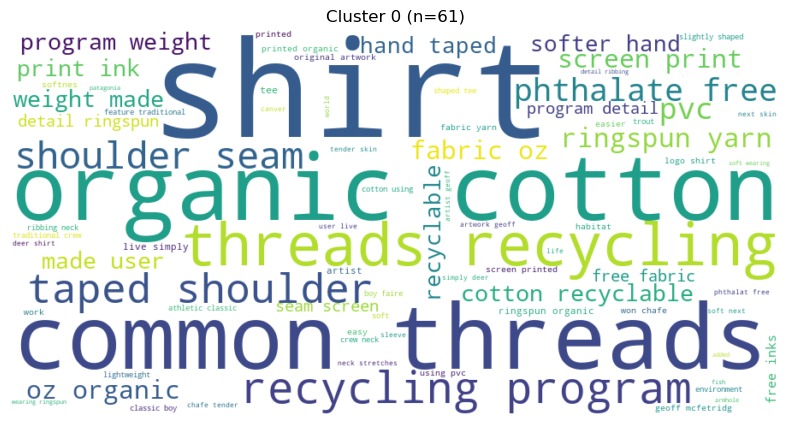

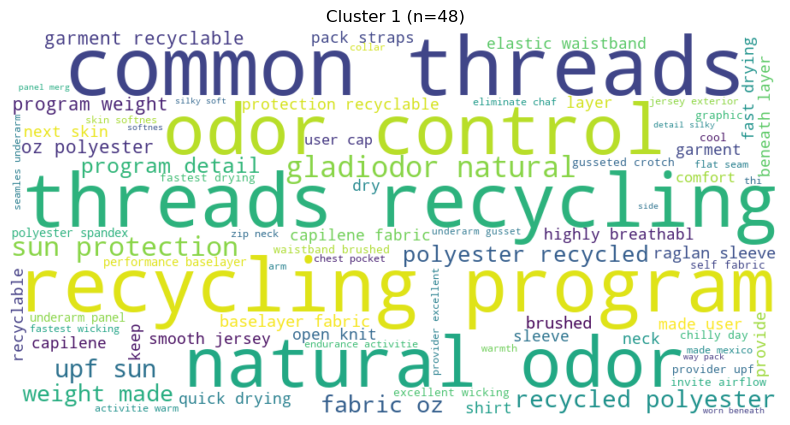

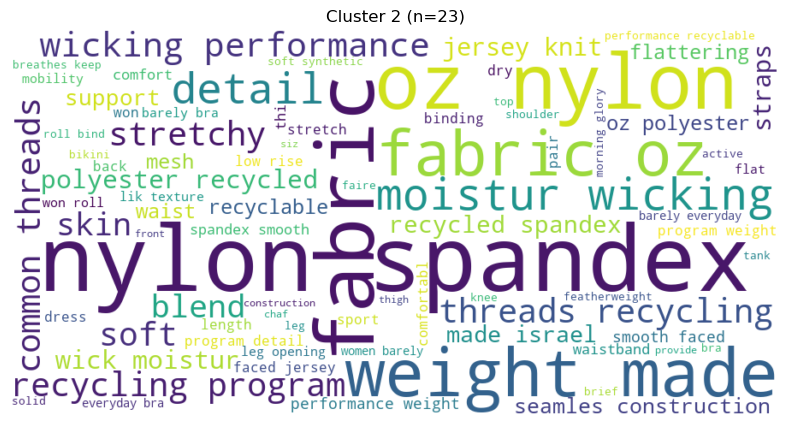

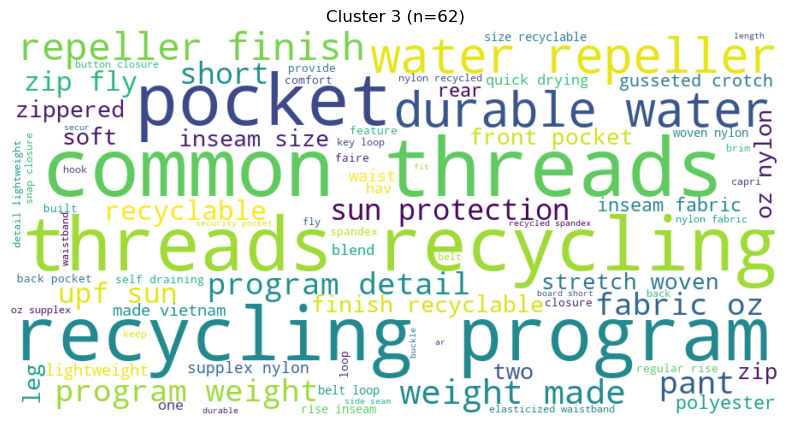

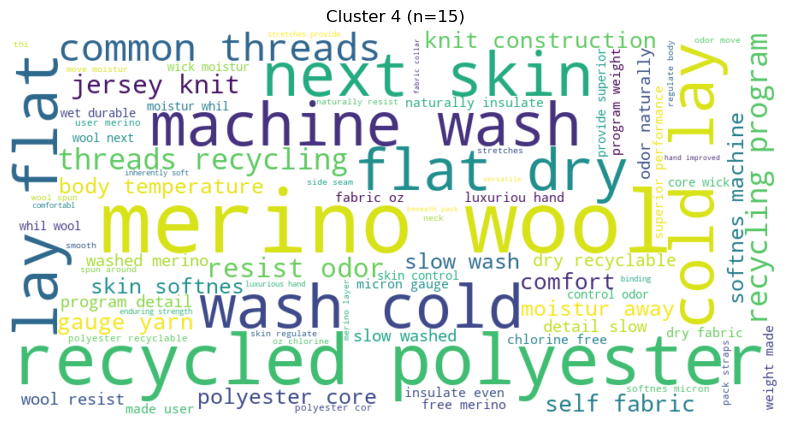

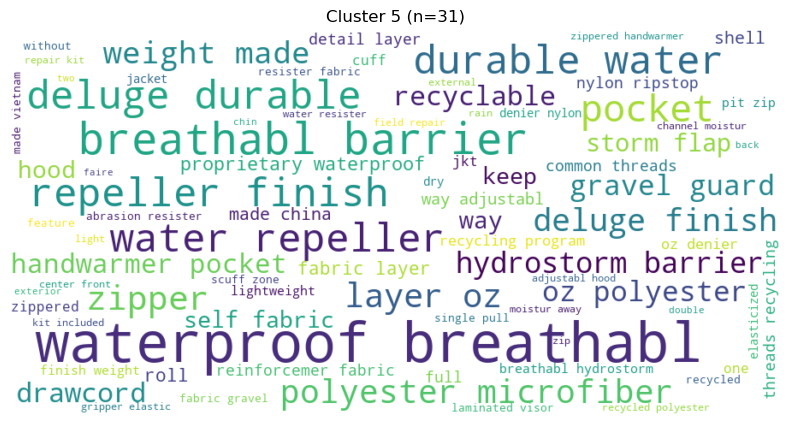

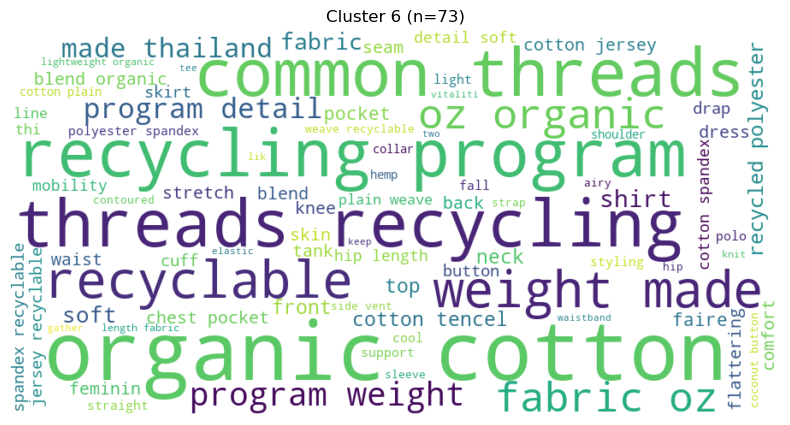

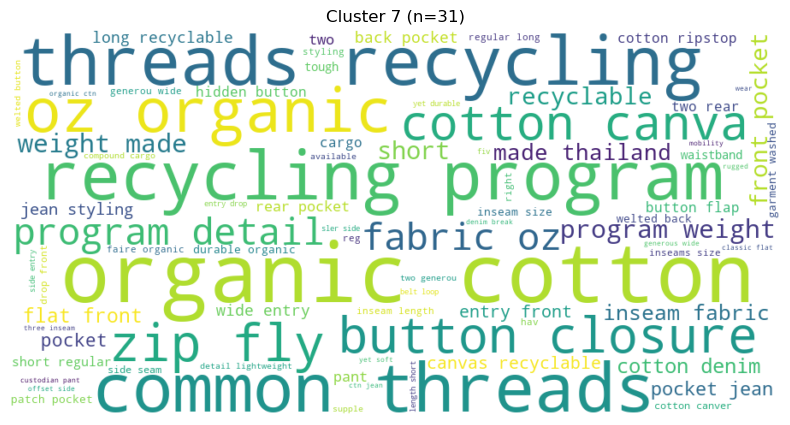

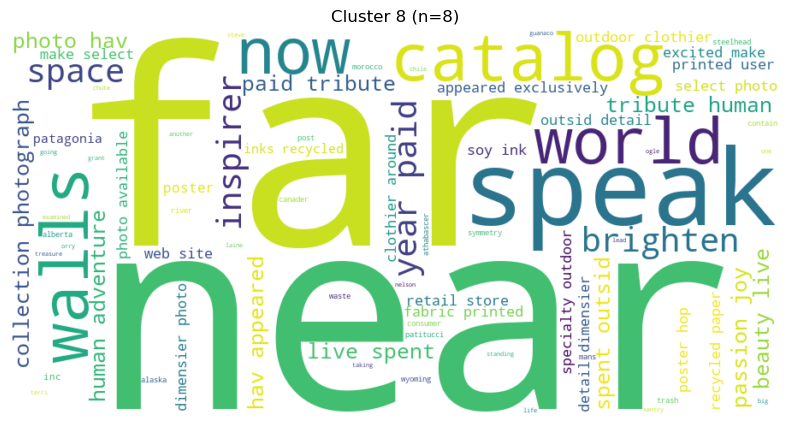

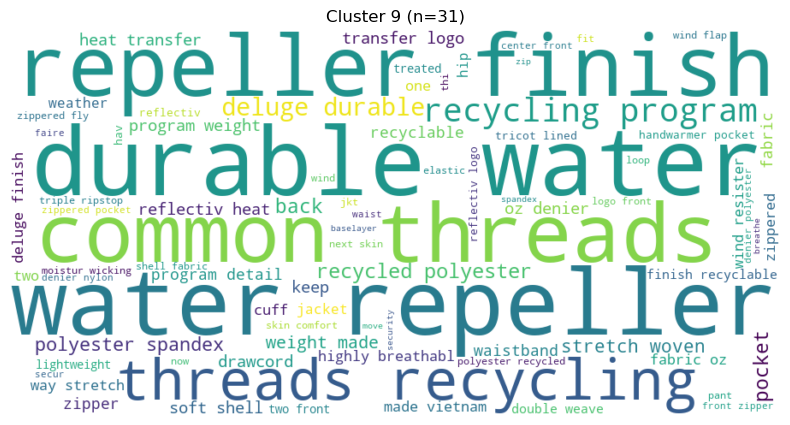

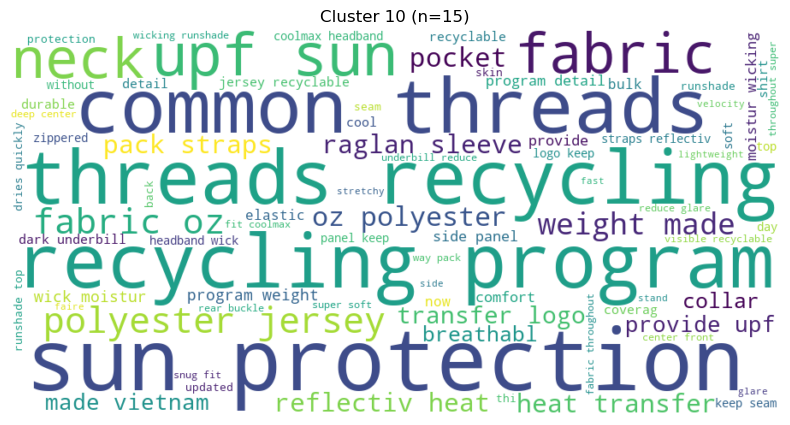

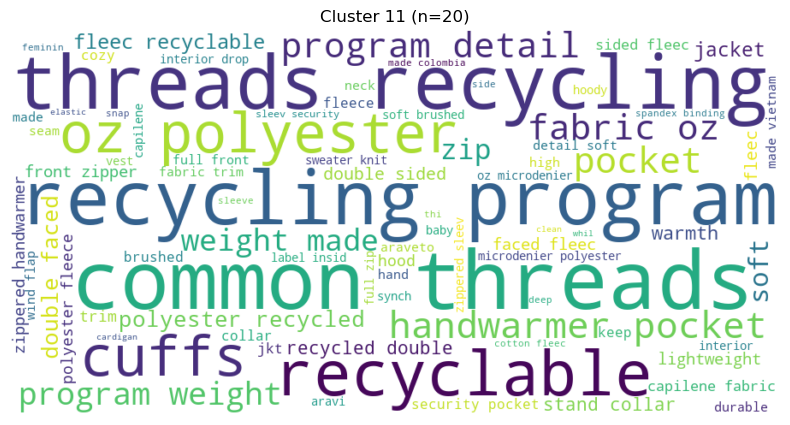

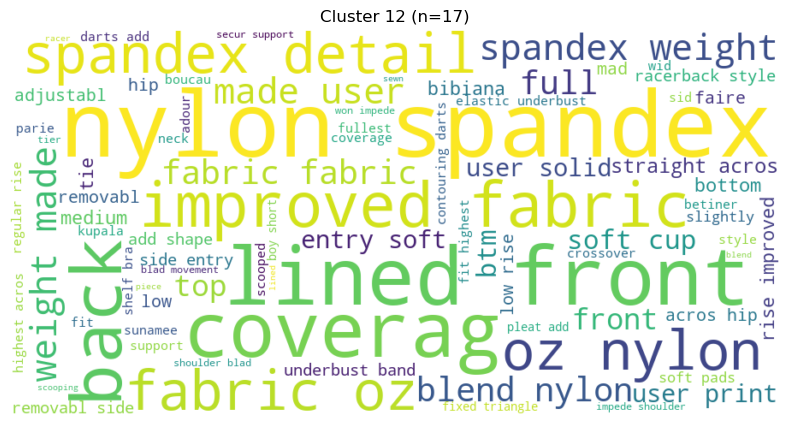

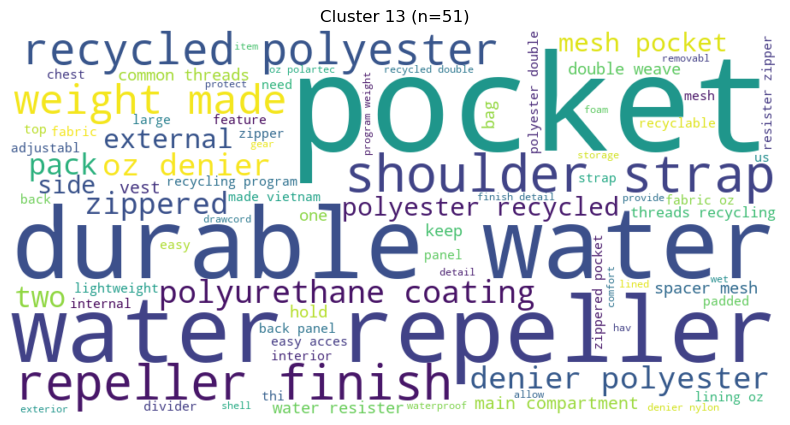

In [49]:
cluster_col = "kmeans_cluster"
text_col = "clean_spacy"

def plot_wordcloud_for_cluster(cluster_id, max_words=80):
    sub = df[df[cluster_col] == cluster_id][text_col].astype(str).tolist()
    text = " ".join(sub)

    wc = WordCloud(
        width=900,
        height=450,
        background_color="white",
        max_words=max_words
    ).generate(text)

    plt.figure(figsize=(12, 5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Cluster {cluster_id} (n={len(sub)})")
    plt.show()

# Exemple : affiche 3 clusters
cluster_ids = sorted(df[cluster_col].unique())

for c in cluster_ids[:14]:
    plot_wordcloud_for_cluster(c)

# Système de recommandation

## Test randomisé

In [43]:
import random

def find_similar_items(product_id, n=5, seed=42):
    """
    Renvoie jusqu'à n identifiants de produits appartenant au même cluster KMeans que product_id.
    """
    # Cluster du produit choisi
    row = df.loc[df["id"] == product_id, "kmeans_cluster"]
    if row.empty:
        raise ValueError(f"product_id inconnu : {product_id}")

    cluster_id = int(row.iloc[0])

    # Candidats dans le même cluster
    candidates = df.loc[
        (df["kmeans_cluster"] == cluster_id) & (df["id"] != product_id),
        "id"
    ]

    # Echantillon
    if len(candidates) == 0:
        return []
    return candidates.sample(min(n, len(candidates)), random_state=seed).tolist()


# Testing
N_tests = 3
product_ids = random.sample(df["id"].tolist(), k=min(N_tests, len(df)))

for pid in product_ids:
    print(f"Produit {pid}. Matching: {find_similar_items(pid)}")


Produit 165. Matching: [2, 299, 258, 3, 301]
Produit 44. Matching: [10, 17, 402, 259, 92]
Produit 142. Matching: [10, 17, 402, 259, 70]


## Saisie du produit par l'utlisateur

In [44]:
def reco_system():
    while True:
        s = input("Product id : ").strip().lower()
        if s == "q":
            break
        if not s.isdigit():
            print("Please enter a numeric id.\n")
            continue

        product_id = int(s)

        row = df.loc[df["id"] == product_id]
        if row.empty:
            print("Product not found.\n")
            continue

        print("\nProduit sélectionné :")
        print(textwrap.shorten(row["description"].iloc[0], width=120, placeholder="..."))

        recos = find_similar_items(product_id, n=5)

        print("\nPour pourriez aussi aimer :")
        for rid in recos:
            rdesc = df.loc[df["id"] == rid, "description"].iloc[0]
            print(f"- {rid}: {textwrap.shorten(rdesc, width=120, placeholder='...')}")
        print()

reco_system()



Produit sélectionné :
Girl's boardie capris - Built for two-week camping trips on Baja beaches, these capris are made of a lightweight,...

Pour pourriez aussi aimer :
- 10: Baby sun bucket hat - This hat goes on when the sun rises above the horizon, and stays on when raindrops start...
- 17: Bucket hat - Besides its shade-casting prowess, the Bucket provides perfect eye cover after an extra-large fish taco...
- 402: River shorts - River life is mighty fine, but even there you occasionally have to wear clothes. Our River Shorts...
- 259: Meridian board shorts - The stretchy Meridian Board Shorts accommodate floaters and drop-knee bottom-turns the globe...
- 92: Minimalist board shorts-19 in. - The Minimalist is perfectly proportioned - nothing wasted, nothing wanted. Made from...


Produit sélectionné :
L/s steersman shirt - This ain't no city shirt, unless you're in Manila. The Steersman is de-twanged ranch hand in a...

Pour pourriez aussi aimer :
- 74: Logo hat - Your unflappable r

# Topic modeling

## Training LSA

In [45]:
n_topics = 15
svd = TruncatedSVD(n_components=n_topics, random_state=42)

topic_matrix = svd.fit_transform(X)

topic_encoded_df = pd.DataFrame(
    topic_matrix,
    columns=[f"topic_{i}" for i in range(n_topics)],
    index=df["id"]
)

# topic principal (pour simplifier l'interprétation)
df["main_topic"] = topic_matrix.argmax(axis=1)

print("topics_encoded_df shape:", topic_encoded_df.shape)
topic_encoded_df.head()

topics_encoded_df shape: (500, 15)


topic_0   topic_1   topic_2   topic_3   topic_4   topic_5   topic_6  \
id                                                                         
1   0.245171  0.160399  0.094268  0.216938 -0.161437 -0.018534 -0.044184   
2   0.241840  0.149882  0.070406  0.087300 -0.045724  0.119233  0.007475   
3   0.232638  0.164937  0.029588  0.095611 -0.029394  0.104703  0.093043   
4   0.286522  0.307906 -0.156995 -0.082703 -0.003238 -0.009055 -0.045350   
5   0.282135  0.326489 -0.235426 -0.033330 -0.017817 -0.068041  0.063018   

     topic_7   topic_8   topic_9  topic_10  topic_11  topic_12  topic_13  \
id                                                                         
1  -0.014035  0.008746 -0.141342 -0.014366  0.040167 -0.046537 -0.003739   
2  -0.024221 -0.012402 -0.085665 -0.084266  0.157167 -0.026732 -0.024304   
3  -0.079057 -0.013449 -0.026735 -0.059205  0.179350  0.032710 -0.030736   
4   0.048042  0.003215 -0.025626 -0.143217  0.032567 -0.142418  0.073748   
5  -0.017489 -0.010632  0.076689 -0.212584 -0.030539 -0.215300 -0.177186   

    topic_14  
id            
1   0.022077  
2   0.012670  
3  -0.002284  
4   0.107575  
5  -0.018544

## Top des mots par topics

In [46]:
terms = np.array(vectorizer.get_feature_names_out())

def top_terms_for_topic(topic_id, top_k=12):
    comp = svd.components_[topic_id]
    top_idx = comp.argsort()[::-1][:top_k]
    return list(terms[top_idx])

for t in range(n_topics):
    print(f"Topic {t}:", top_terms_for_topic(t, top_k=12))


Topic 0: ['organic', 'cotton', 'organic cotton', 'recyclable', 'shirt', 'common threads', 'common', 'threads', 'recycling', 'program', 'recyclable common', 'threads recycling']
Topic 1: ['pocket', 'polyester', 'water', 'recycled', 'zippered', 'nylon', 'finish', 'durable', 'water repeller', 'repeller', 'durable water', 'repeller finish']
Topic 2: ['organic', 'cotton', 'organic cotton', 'button', 'inseam', 'tencel', 'short', 'cotton tencel', 'thailand', 'weight thailand', 'oz organic', 'jean']
Topic 3: ['merino', 'odor', 'wool', 'control', 'merino wool', 'gladiodor', 'natural odor', 'odor control', 'gladiodor natural', 'natural', 'capilene', 'skin']
Topic 4: ['merino', 'wool', 'merino wool', 'wash', 'machine', 'cold lay', 'wash cold', 'machine wash', 'flat dry', 'slow', 'lay flat', 'lay']
Topic 5: ['nylon', 'nylon spandex', 'spandex', 'coverag', 'oz nylon', 'improved fabric', 'sun', 'spandex weight', 'rise', 'blend nylon', 'lined', 'blend']
Topic 6: ['spandex', 'nylon spandex', 'tencel',

## Wordcloud par topic

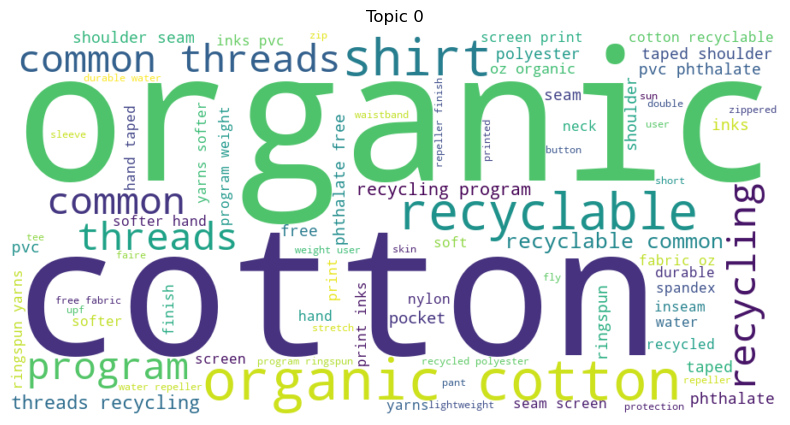

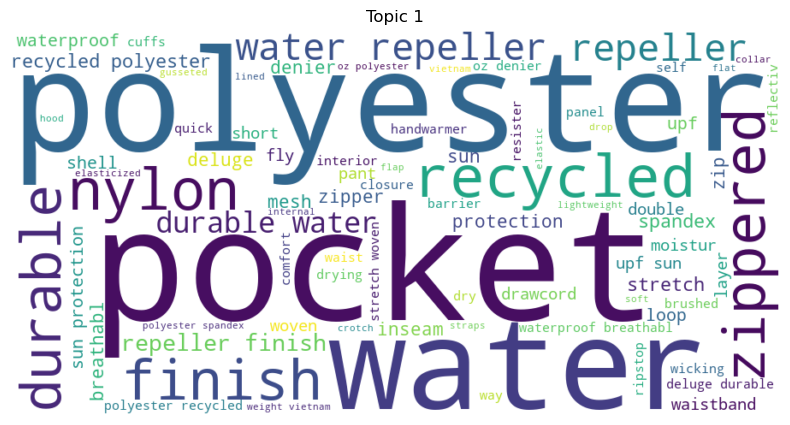

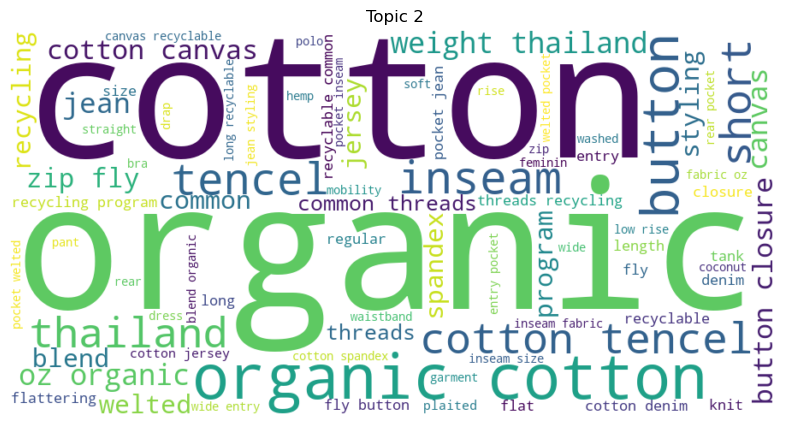

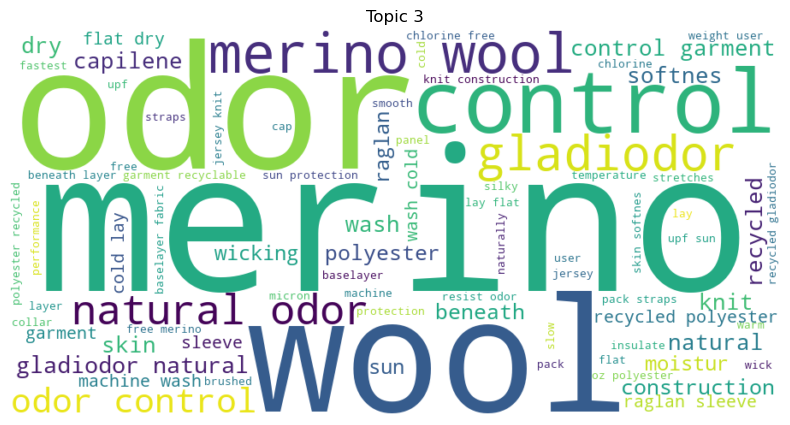

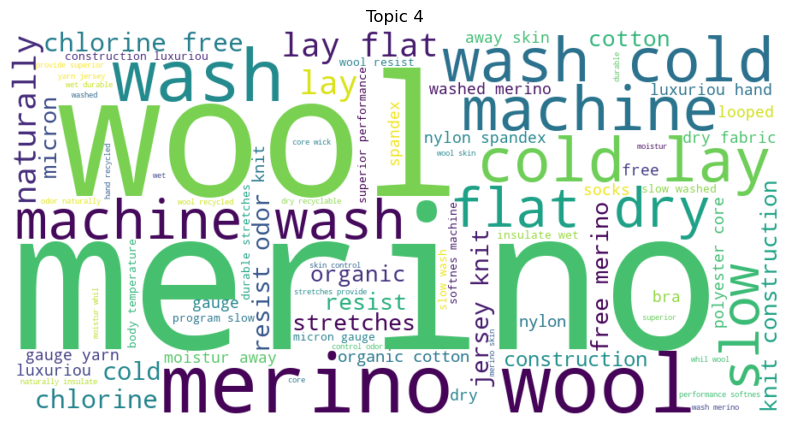

In [47]:
def plot_wordcloud_for_topic(topic_id, max_words=80, top_n_terms=300):
    comp = svd.components_[topic_id]
    top_idx = comp.argsort()[::-1][:top_n_terms]

    # wordcloud attend des fréquences positives
    freqs = {terms[i]: float(comp[i]) for i in top_idx if comp[i] > 0}

    wc = WordCloud(
        width=900,
        height=450,
        background_color="white",
        max_words=max_words
    ).generate_from_frequencies(freqs)

    plt.figure(figsize=(12, 5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Topic {topic_id}")
    plt.show()

# Exemple : afficher 5 topics
for t in range(5):
    plot_wordcloud_for_topic(t)


## Répartition des topics principaux

In [54]:
counts = df["main_topic"].value_counts().sort_index().reset_index()
counts.columns = ["topic", "count"]
counts["topic"] = counts["topic"].astype(str)

fig = px.bar(counts, x="topic", y="count", text="count",
             title="Distribution des topics",
             labels={"topic":"Topic", "count":"# products"})
fig.update_traces(textposition="outside", cliponaxis=False)
fig.show()
